In [1]:
import pandas as pd
import wikipedia as wp
import requests
import pgeocode
import folium
import seaborn as sns
html = wp.page("List_of_postal_codes_of_Canada:_M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.head(10)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [2]:
 df['Neighborhood'] = df['Borough'].where(df['Neighborhood'] == 'Not assigned' , df['Neighborhood'])

In [3]:
df = df[df.Borough != 'Not assigned']

In [4]:
df.shape

(103, 3)

In [5]:
col_one_list = list(df['Postal Code'])

In [6]:
nomi = pgeocode.Nominatim('ca')
df1=nomi.query_postal_code(col_one_list)

In [7]:
new_df=df.merge(df1[['latitude','longitude','postal_code']],left_on='Postal Code',
                right_on='postal_code',how='left').drop('postal_code',axis=1)

In [8]:
new_df.head(10)

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6662,-79.5282
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
7,M3B,North York,Don Mills,43.7450,-79.3590
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


### Filtering Downtown

In [9]:
new_df=new_df.set_index('Borough').filter(like='Downtown', axis=0)
new_df=new_df.reset_index() 
new_df=new_df.dropna(subset=['longitude'])
new_df=new_df.dropna(subset=['latitude'])
new_df.head(10)

,Borough,Postal Code,Neighborhood,latitude,longitude
0,Downtown Toronto,M5A,"Regent Park, Harbourfront",43.6555,-79.3626
1,Downtown Toronto,M7A,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,Downtown Toronto,M5B,"Garden District, Ryerson",43.6572,-79.3783
3,Downtown Toronto,M5C,St. James Town,43.6513,-79.3756
4,Downtown Toronto,M5E,Berczy Park,43.6456,-79.3754
5,Downtown Toronto,M5G,Central Bay Street,43.6564,-79.3860
6,Downtown Toronto,M6G,Christie,43.6683,-79.4205
7,Downtown Toronto,M5H,"Richmond, Adelaide, King",43.6496,-79.3833
8,Downtown Toronto,M5J,"Harbourfront East, Union Station, Toronto Islands",43.6230,-79.3936
9,Downtown Toronto,M5K,"Toronto Dominion Centre, Design Exchange",43.6469,-79.3823


In [10]:
latitude = list(new_df['latitude'])
longitude = list(new_df['longitude'])
m = folium.Map(location=[43.65,-79.36], zoom_start=13)
for latitude, longitude, borough, neighborhood in zip(new_df['latitude'], new_df['longitude'], new_df['Borough'], new_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m)    
m

In [11]:
CLIENT_ID = 'EUKQYYPILCYL1XXZ242LUPF40CO2XQISTYOPCECAD5A2LAYO' # your Foursquare ID
CLIENT_SECRET = 'FQRNMFFHJ3KUTBBGPO3OPNTNGFRZZJBI4ZY5D3B1XSAS1133' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Filtering nearby Bar

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500# define radius
search_query = 'bar'
neighborhood_latitude  = new_df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = new_df.loc[0, 'longitude'] # neighborhood longitude value
neighborhood_name      = new_df.loc[0, 'Neighborhood'] # neighborhood name
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    search_query,
    LIMIT)

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f115740f5887b50511ebf77'},
 'response': {'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'bar',
  'totalResults': 102,
  'suggestedBounds': {'ne': {'lat': 43.66900001350002,
    'lng': -79.34397561584306},
   'sw': {'lat': 43.64199998649999, 'lng': -79.38122438415694}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae7c386f964a52094ad21e3',
       'name': "Betty's",
       'location': {'address': '240 King St. E',
        'crossStreet': 'btwn. Sherbourne St. and Princess St.',
        'lat': 43.65158716627337,
        'lng': -79.36751495404803,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65158716627337,
          'lng': -79

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
bar = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bar =bar.loc[:, filtered_columns]

# filter the category for each row
bar['venue.categories'] = bar.apply(get_category_type, axis=1)

# clean columns
bar.columns = [col.split(".")[-1] for col in bar.columns]

bar.shape
bar.head(10)

,name,categories,lat,lng
0,Betty's,Bar,43.651587,-79.367515
1,I’ll Be Seeing You,Bar,43.659250,-79.348121
2,Farside,Bar,43.665681,-79.351742
3,The Comrade,Bar,43.659346,-79.347932
4,D.W. Alexander,Bar,43.648333,-79.373826
5,Triple A Bar (AAA),Bar,43.651658,-79.372720
6,Mill St. Brew Pub,Pub,43.650353,-79.358489
7,Hi-Lo,Dive Bar,43.659254,-79.348035
8,Pravda Vodka Bar,Bar,43.648516,-79.374732
9,Dominion Pub and Kitchen,Pub,43.656919,-79.358967


In [16]:
bar['categories'].unique()

array(['Bar', 'Pub', 'Dive Bar', 'Coffee Shop', 'Gastropub',
       'Mexican Restaurant', 'Café', 'Italian Restaurant', 'Beer Bar',
       'Restaurant', 'American Restaurant', 'Seafood Restaurant', 'Hotel',
       'Rock Club', 'Diner', 'Brewery', 'Sports Bar', 'Cocktail Bar',
       'Karaoke Bar', 'Burger Joint', 'Bistro', 'Lounge', 'Wine Bar',
       'BBQ Joint', 'New American Restaurant', 'Fast Food Restaurant',
       'Sushi Restaurant', 'Other Nightlife', 'Hotel Bar', 'Speakeasy',
       'Gay Bar', 'Smoke Shop', 'Spa'], dtype=object)

We have some other categories included so only bar and pub are included

In [17]:
bar= bar.loc[bar['categories'].isin(['Bar','Pub','Karaoke Bar','Gastropub','Brewery'])]
bar.head(10)

,name,categories,lat,lng
0,Betty's,Bar,43.651587,-79.367515
1,I’ll Be Seeing You,Bar,43.659250,-79.348121
2,Farside,Bar,43.665681,-79.351742
3,The Comrade,Bar,43.659346,-79.347932
4,D.W. Alexander,Bar,43.648333,-79.373826
5,Triple A Bar (AAA),Bar,43.651658,-79.372720
6,Mill St. Brew Pub,Pub,43.650353,-79.358489
8,Pravda Vodka Bar,Bar,43.648516,-79.374732
9,Dominion Pub and Kitchen,Pub,43.656919,-79.358967
11,Beerbistro,Gastropub,43.649419,-79.377237


In [18]:
for lat, lng, label in zip(bar.lat, bar.lng, bar.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        popup=label,
        fill_opacity=0.6
    ).add_to(m)

# display map
m

In [19]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
bar["name_one"] = LE.fit_transform(bar["name"])
bar["categories_one"] = LE.fit_transform(bar["categories"])
bar.head(10)

,name,categories,lat,lng,name_one,categories_one
0,Betty's,Bar,43.651587,-79.367515,6,0
1,I’ll Be Seeing You,Bar,43.659250,-79.348121,17,0
2,Farside,Bar,43.665681,-79.351742,12,0
3,The Comrade,Bar,43.659346,-79.347932,38,0
4,D.W. Alexander,Bar,43.648333,-79.373826,9,0
5,Triple A Bar (AAA),Bar,43.651658,-79.372720,46,0
6,Mill St. Brew Pub,Pub,43.650353,-79.358489,23,4
8,Pravda Vodka Bar,Bar,43.648516,-79.374732,30,0
9,Dominion Pub and Kitchen,Pub,43.656919,-79.358967,10,4
11,Beerbistro,Gastropub,43.649419,-79.377237,5,2


In [20]:
bar2= bar[bar.columns[2::]]
bar2.head(10)

,lat,lng,name_one,categories_one
0,43.651587,-79.367515,6,0
1,43.659250,-79.348121,17,0
2,43.665681,-79.351742,12,0
3,43.659346,-79.347932,38,0
4,43.648333,-79.373826,9,0
5,43.651658,-79.372720,46,0
6,43.650353,-79.358489,23,4
8,43.648516,-79.374732,30,0
9,43.656919,-79.358967,10,4
11,43.649419,-79.377237,5,2


In [21]:
# set number of clusters
from sklearn.cluster import KMeans
import numpy as np
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmeans.fit(bar2)
    distortions.append(kmeans.inertia_)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 5, 4, 2, 1, 7, 3, 5, 2])

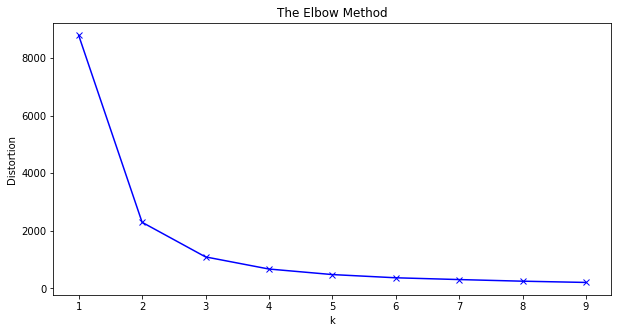

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

According to elbow method 2 kmeans should be selected

In [24]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(bar2)
bar['cluster'] = kmeans.labels_
bar= bar[['name','categories','lat','lng','cluster']]
bar.head(10)

,name,categories,lat,lng,cluster
0,Betty's,Bar,43.651587,-79.367515,1
1,I’ll Be Seeing You,Bar,43.659250,-79.348121,1
2,Farside,Bar,43.665681,-79.351742,1
3,The Comrade,Bar,43.659346,-79.347932,0
4,D.W. Alexander,Bar,43.648333,-79.373826,1
5,Triple A Bar (AAA),Bar,43.651658,-79.372720,0
6,Mill St. Brew Pub,Pub,43.650353,-79.358489,0
8,Pravda Vodka Bar,Bar,43.648516,-79.374732,0
9,Dominion Pub and Kitchen,Pub,43.656919,-79.358967,1
11,Beerbistro,Gastropub,43.649419,-79.377237,1
